# Neural Dual Solver 

This tutorial shows how to use `OTT` to compute the Wasserstein-4 optimal transport map between continuous measures in Euclidean space that are accessible via sampling.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` solves this
problem by optimizing parameterized Kantorovich dual potential functions
and returning a  {class}`~ott.problems.linear.potentials.DualPotentials`
object that can be used to transport unseen source data samples to its target distribution (or vice-versa) or compute the corresponding distance between new source and target distribution.

The dual potentials can be specified as non-convex neural networks
({class}`~ott.solvers.nn.mlp.MLP`) or an
input-convex neural network ({class}`~ott.solvers.nn.icnn.ICNN`) {cite}`amos:17`.
{class}`~ott.solvers.nn.neuraldual.W2NeuralDual` implements the
method developed by {cite}`makkuva:20`
along with the improvements and fine-tuning of the
conjugate computation from {cite}`amos:23`.
For more insights on the approach itself, we refer the user
to the original sources.

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
from dataclasses import dataclass
from functools import partial

from IPython.display import clear_output, display

import jax
import jax.numpy as jnp
import numpy as np
import optax
from torch.utils.data import DataLoader, IterableDataset

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.linear import potentials
from ott.solvers.nn import icnn, mlp, neuraldual
from ott.tools import sinkhorn_divergence

## Setup Training and Validation Datasets

We apply the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` to compute the transport between toy datasets. In this tutorial, the user can choose between the datasets `simple` (data clustered in one center), `circle` (two-dimensional Gaussians arranged on a circle), `square_five` (two-dimensional Gaussians on a square with one Gaussian in the center), and `square_four` (two-dimensional Gaussians in the corners of a rectangle).

In [3]:
@dataclass
class ToyDataset:
    name: str
    batch_size: int
    init_seed: int

    def __iter__(self):
        return self.create_sample_generators()

    def create_sample_generators(self, scale=5.0, variance=0.5):
        # given name of dataset, select centers
        if self.name == "simple":
            centers = np.array([[0, 0]])

        elif self.name == "circle":
            centers = np.array(
                [
                    (1, 0),
                    (-1, 0),
                    (0, 1),
                    (0, -1),
                    (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
                    (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
                ]
            )

        elif self.name == "square_five":
            centers = np.array([[0, 0], [1, 1], [-1, 1], [-1, -1], [1, -1]])

        elif self.name == "square_four":
            centers = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])

        else:
            raise NotImplementedError()

        # create generator which randomly picks center and adds noise
        centers = scale * centers
        key = jax.random.PRNGKey(self.init_seed)
        while True:
            k1, k2, key = jax.random.split(key, 3)
            sample_centers = jax.random.choice(k1, centers, [self.batch_size])
            samples = sample_centers + variance**2 * jax.random.normal(
                k2, [self.batch_size, 2]
            )
            yield samples


def load_toy_data(
    name_source: str,
    name_target: str,
    batch_size: int = 1024,
    valid_batch_size: int = 1000,
):
    dataloaders = (
        iter(ToyDataset(name_source, batch_size=batch_size, init_seed=0)),
        iter(ToyDataset(name_target, batch_size=batch_size, init_seed=1)),
        iter(ToyDataset(name_source, batch_size=valid_batch_size, init_seed=2)),
        iter(ToyDataset(name_target, batch_size=valid_batch_size, init_seed=3)),
    )
    input_dim = 2
    return dataloaders, input_dim

## Solve Neural Dual

In order to solve the neural dual, we need to define our dataloaders. The only requirement is that the corresponding source and target train and validation datasets are *iterators*.

In [4]:
(
    dataloader_source,
    dataloader_target,
    dataloader_source_eval,
    dataloader_target_eval,
), input_dim = load_toy_data("simple", "circle")

(<Figure size 800x400 with 2 Axes>,
 <AxesSubplot: title={'center': 'Target measure samples'}>)

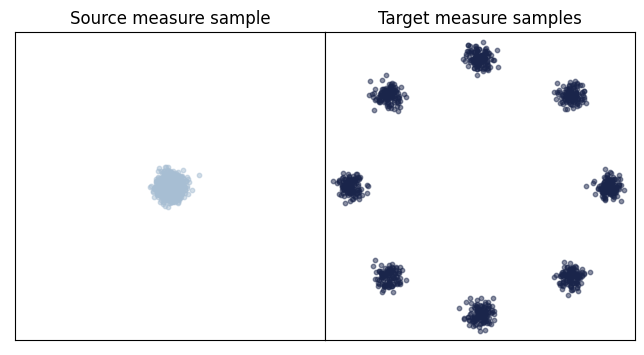

In [5]:
def plot_samples(eval_data_source, eval_data_target):
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 4), gridspec_kw={"wspace": 0, "hspace": 0}
    )
    axs[0].scatter(
        eval_data_source[:, 0],
        eval_data_source[:, 1],
        color="#A7BED3",
        s=10,
        alpha=0.5,
    )
    axs[0].set_title("Source measure sample")
    axs[1].scatter(
        eval_data_target[:, 0],
        eval_data_target[:, 1],
        color="#1A254B",
        s=10,
        alpha=0.5,
    )
    axs[1].set_title("Target measure samples")

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)
    return fig, ax


# Sample a batch for evaluation and plot it
eval_data_source = next(dataloader_source_eval)
eval_data_target = next(dataloader_target_eval)

plot_samples(eval_data_source, eval_data_target)

Next, we define the architectures parameterizing the dual potentials $f$ and $g$. We first parameterize $f$ with an {class}`~ott.solvers.nn.icnn.ICNN` and $\nabla g$ as a non-convex {class}`~ott.solvers.nn.mlp.MLP`. You can adapt the size of the ICNNs by passing a sequence containing hidden layer sizes. While ICNNs are by default containing partially positive weights, we can run the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` using approximations to this positivity constraint (via weight clipping and a weight penalization). For this, set `positive_weights` to `True` in both the ICNN architecture and {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` configuration. For more details on how to customize the {class}`~ott.solvers.nn.icnn.ICNN` architectures, we refer you to the documentation.

In [6]:
# initialize models and optimizers
num_train_iters = 5001

neural_f = icnn.ICNN(dim_data=2, dim_hidden=[128, 128])
neural_g = mlp.MLP(
    dim_hidden=[128, 128],
    is_potential=False,  # returns the gradient of the potential.
)

lr_schedule = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adam(learning_rate=lr_schedule, b1=0.5, b2=0.5)
optimizer_g = optax.adam(learning_rate=lr_schedule, b1=0.9, b2=0.999)

We then initialize the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` by passing the two {class}`~ott.solvers.nn.icnn.ICNN` models parameterizing $f$ and $g$, as well as by specifying the input dimensions of the data and the number of training iterations to execute. Once the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual` is initialized, we can obtain the neural {class}`~ott.problems.linear.potentials.DualPotentials` by passing the corresponding dataloaders to it. As here our training and validation datasets do not differ, we pass (`dataloader_source`, `dataloader_target`) for both training and validation steps. For more details on how to configure the {class}`~ott.solvers.nn.neuraldual.W2NeuralDual`, we refer you to the documentation.

<font color='#F2545B'>Execution of the following cell might take a few minutes, depending on your system and the number of training iterations.</font>

In [7]:
def training_callback(step, learned_potentials):
    # Callback function as the training progresses to visualize the couplings.
    if step % 1000 == 0:
        clear_output()
        print(f"Training iteration: {step}/{num_train_iters}")

        fig, ax = potentials.plot_ot_map(
            learned_potentials,
            eval_data_source,
            eval_data_target,
            inverse=False,
        )
        display(fig)
        plt.close(fig)

        fig, ax = potentials.plot_ot_map(
            learned_potentials, eval_data_target, eval_data_source, inverse=True
        )
        display(fig)
        plt.close(fig)

        fig, ax = potentials.plot_potential(learned_potentials)
        display(fig)
        plt.close(fig)


neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
    back_and_forth=False,
)
learned_potentials = neural_dual_solver(
    dataloader_source,
    dataloader_target,
    dataloader_source,
    dataloader_target,
    callback=training_callback,
)
clear_output()

The `learned_potentials` object gives us access to the learned potentials along with functions to compute the forward and inverse OT maps between the measures.

(<Figure size 600x600 with 2 Axes>, <AxesSubplot: title={'center': '$g$'}>)

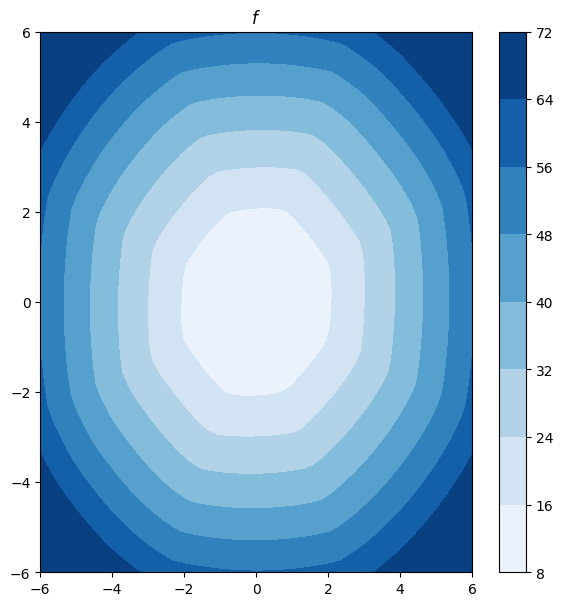

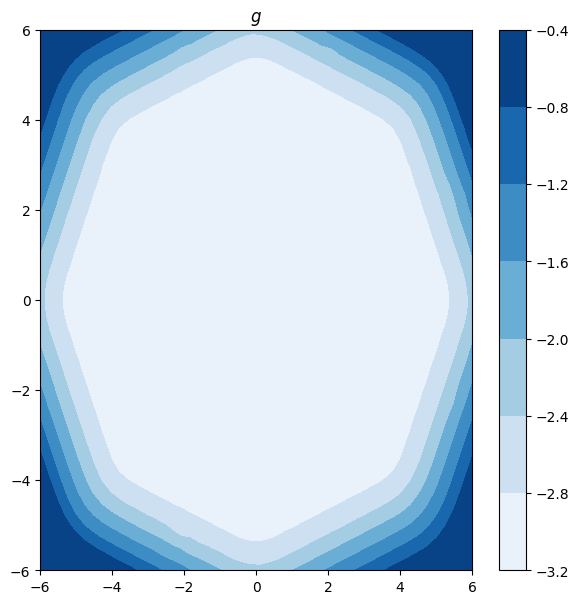

In [8]:
potentials.plot_potential(learned_potentials)
potentials.plot_potential(learned_potentials, inverse=True)

## Evaluate Neural Dual

After training has completed successfully, we can evaluate the neural {class}`~ott.problems.linear.potentials.DualPotentials` on unseen incoming data. We first sample a new batch from the source and target distribution.

Now, we can plot the corresponding transport from source to target using the gradient of the learning potential $g$, i.e., $\nabla g(\text{source})$, or from target to source via the gradient of the learning potential $f$, i.e., $\nabla f(\text{target})$.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

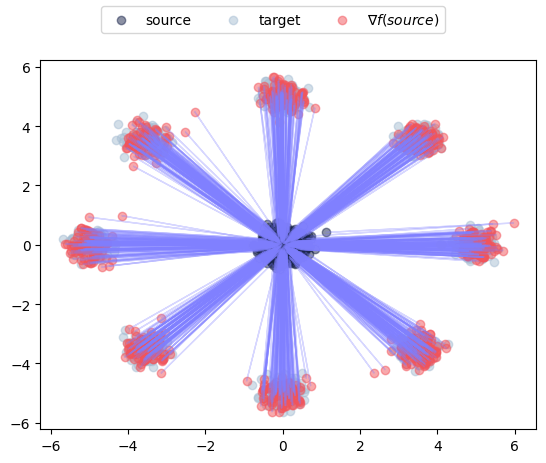

In [9]:
potentials.plot_ot_map(
    learned_potentials, eval_data_source, eval_data_target, inverse=False
)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

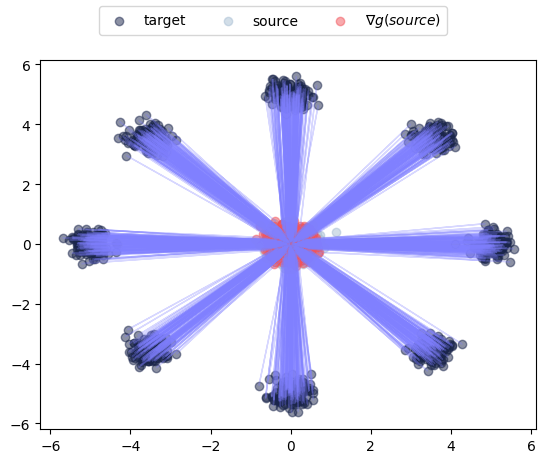

In [10]:
potentials.plot_ot_map(
    learned_potentials, eval_data_target, eval_data_source, inverse=True
)

We further test, how close the predicted samples are to the sampled data.

First for potential $g$, transporting source to target samples. Ideally the resulting {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance is close to $0$.

In [11]:
@jax.jit
def sinkhorn_loss(x, y, epsilon=0.1):
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence

In [12]:
pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)

Sinkhorn distance between source predictions and data samples: 0.31


Then for potential $f$, transporting target to source samples. Again, the resulting {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance needs to be close to $0$.

In [13]:
pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

Sinkhorn distance between source predictions and data samples: 0.00


Besides computing the transport and mapping source to target samples or vice versa, we can also compute the overall distance between new source and target samples.

In [14]:
neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

Neural dual distance between source and target data: 22.08


Which compares to the primal {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` distance in the following.

In [15]:
sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")

Sinkhorn distance between source and target data: 22.11


## Solving a harder problem

We next set up a harder OT problem to transport from a mixture
of five Gaussians to a mixture of four Gaussians and solve
it by using the non-convex {class}`~ott.solvers.nn.mlp.MLP`
potentials to model $f$ and $g$.

(<Figure size 800x400 with 2 Axes>,
 <AxesSubplot: title={'center': 'Target measure samples'}>)

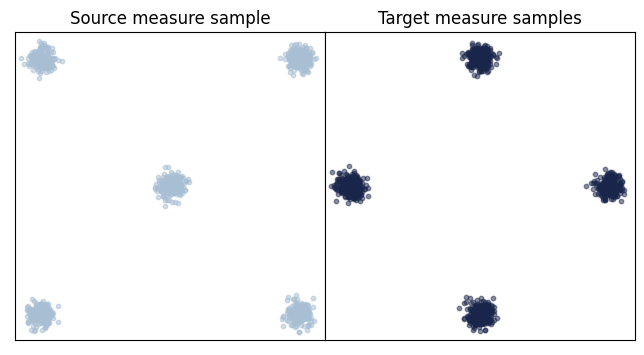

In [16]:
(
    dataloader_source,
    dataloader_target,
    dataloader_source_eval,
    dataloader_target_eval,
), input_dim = load_toy_data("square_five", "square_four")

eval_data_source = next(dataloader_source_eval)
eval_data_target = next(dataloader_target_eval)
plot_samples(eval_data_source, eval_data_target)

In [17]:
num_train_iters = 20001

neural_f = mlp.MLP(dim_hidden=[128, 128])
neural_g = mlp.MLP(dim_hidden=[128, 128])

lr_schedule = optax.cosine_decay_schedule(
    init_value=5e-4, decay_steps=num_train_iters, alpha=1e-2
)
optimizer_f = optax.adamw(learning_rate=lr_schedule)
optimizer_g = optimizer_f

neural_dual_solver = neuraldual.W2NeuralDual(
    input_dim,
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g,
    num_train_iters=num_train_iters,
)
learned_potentials = neural_dual_solver(
    dataloader_source,
    dataloader_target,
    dataloader_source,
    dataloader_target,
    callback=training_callback,
)
clear_output()

We can run the same visualizations and Wasserstein-2 distance estimations as before:

Sinkhorn distance between target predictions and data samples: 1.05
Sinkhorn distance between source predictions and data samples: 3.00
Neural dual distance between source and target data: 20.94
Sinkhorn distance between source and target data: 21.10


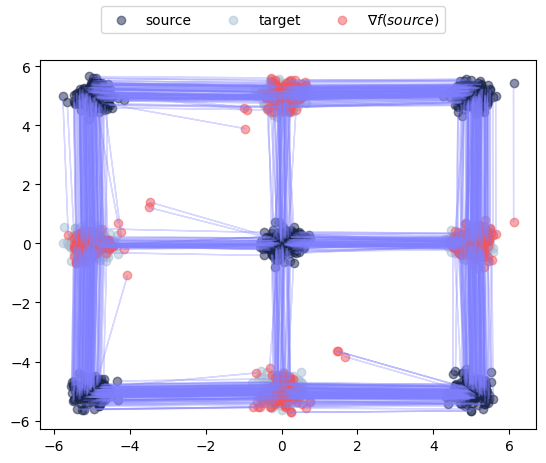

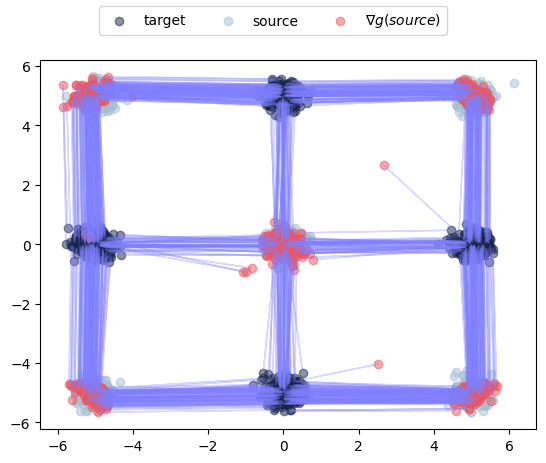

In [18]:
potentials.plot_ot_map(
    learned_potentials, eval_data_source, eval_data_target, inverse=False
)
potentials.plot_ot_map(
    learned_potentials, eval_data_target, eval_data_source, inverse=True
)

pred_target = learned_potentials.transport(eval_data_source)
print(
    f"Sinkhorn distance between target predictions and data samples: {sinkhorn_loss(pred_target, eval_data_target):.2f}"
)


pred_source = learned_potentials.transport(eval_data_target, forward=False)
print(
    f"Sinkhorn distance between source predictions and data samples: {sinkhorn_loss(pred_source, eval_data_source):.2f}"
)

neural_dual_dist = learned_potentials.distance(
    eval_data_source, eval_data_target
)
print(
    f"Neural dual distance between source and target data: {neural_dual_dist:.2f}"
)

sinkhorn_dist = sinkhorn_loss(eval_data_source, eval_data_target)
print(f"Sinkhorn distance between source and target data: {sinkhorn_dist:.2f}")